# Analyze Model

How well does our trained model perform on unseen data? 

In [30]:
import tensorflow as tf
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np 
from scipy import stats

import os

# Loss Curve Analysis

Load the (directory of) losses

In [11]:
loss_dir = 'March 21st'
loss_files = os.listdir(f'loss/{loss_dir}')

Load each loss curve, also keeping track of the particular instance

In [9]:
losses = {}
for loss in loss_files:
    with open(f'loss/{loss_dir}/{loss}', 'rb') as f:
        temp = pd.read_csv(f)
    losses[loss] = temp

Store the validation loss to quantify performance ... which one did the best? 

In [10]:
train_mse = {}
test_mse = {}

for loss in loss_files:

    train_mse[loss]=float(np.sqrt(losses[loss]['loss'].tail(1)))
    test_mse[loss]=float(np.sqrt(losses[loss]['val_loss'].tail(1)))

# What is the 'best performing' model?
    

C:\Users\tjaou104\AppData\Local\Temp\ipykernel_23288\2128013759.py:6: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  train_mse[loss]=float(np.sqrt(losses[loss]['loss'].tail(1)))
C:\Users\tjaou104\AppData\Local\Temp\ipykernel_23288\2128013759.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  test_mse[loss]=float(np.sqrt(losses[loss]['val_loss'].tail(1)))


In [11]:
train_mse

{'loss_train10.csv': 0.0009672867123782904,
 'loss_train11.csv': 0.0010146919944519894,
 'loss_train2.csv': 0.018865187211406093,
 'loss_train3.csv': 0.0018220415785729107,
 'loss_train4.csv': 0.0006915964099404769,
 'loss_train5.csv': 0.001788816450984078,
 'loss_train6.csv': 0.0003449582139370178,
 'loss_train7.csv': 0.0015906634363076712,
 'loss_train8.csv': 0.0009987704586661614,
 'loss_train9.csv': 0.0008864350187936729}

Factoring in the Feburary 28 loss curves, this takes into account the variables 'solar_radiation', 'temperature', 'CN^2', 'Relative Humidity' ... maybe make a scatter plot? 

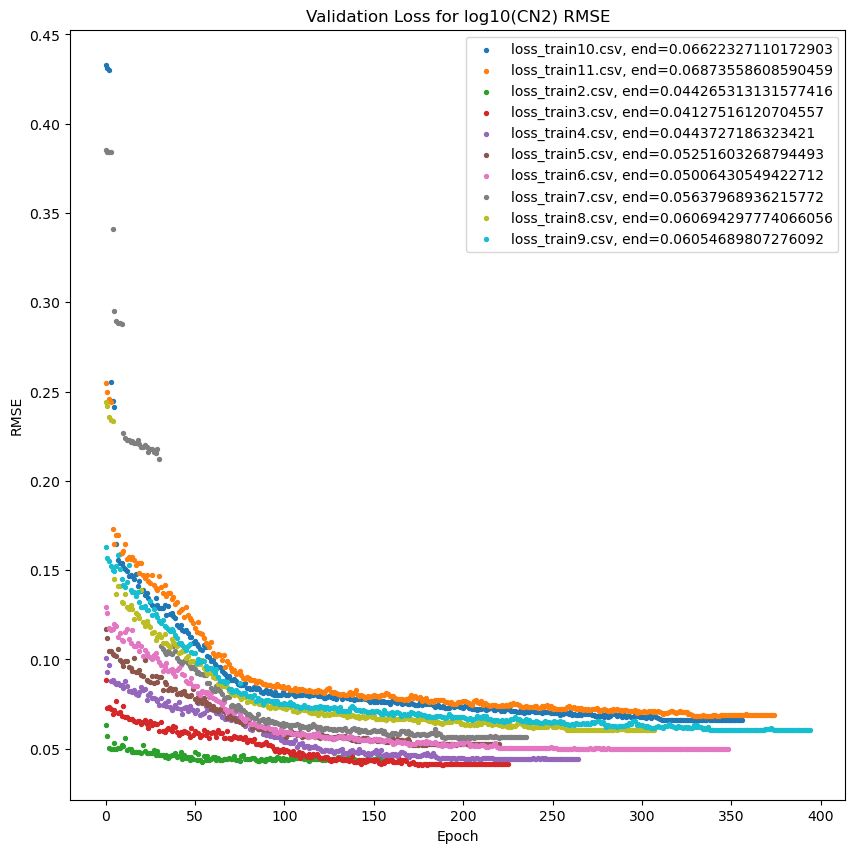

In [12]:
plt.figure(figsize=(10,10))
for ii, loss in enumerate(loss_files):
    y = np.sqrt(losses[loss]['val_loss'][:])
    epochs = np.arange(len(y))
    plt.scatter(epochs, y, s=8, label=f'{loss}, end={test_mse[loss]}')
    
plt.title('Validation Loss for log10(CN2) RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()

Make a line plot similar to the paper

In [7]:
num_of_hours = [1,2,3,4,6,12]
tester_mse = [test_mse['loss_oneHour_7006.csv'], test_mse['loss_twoHour_3484.csv'],test_mse['loss_threeHour_6371.csv'], test_mse['loss_fourHour_7641.csv'], test_mse['loss_sixHour_1152.csv'], test_mse['loss_twelveHour_1654.csv']]  
plt.plot(num_of_hours, tester_mse, marker='o')

plt.xlabel('Number of Hours Ahead')
plt.ylabel('Validation RMSE on Log10(CN2)')

KeyError: 'loss_oneHour_7006.csv'

In [25]:
test_mse['loss_oneHour_7006.csv']

TypeError: list indices must be integers or slices, not str

# Testing Model Predictions

Choose input features

In [2]:
input_features = ['solar_radiation', 'relative_humidity', 'CN2',  'temperature']

In [3]:
input_features

['solar_radiation', 'relative_humidity', 'CN2', 'temperature']

Load the data

In [4]:
from augmentation import jitter, window_slice, window_warp

difference = -1

# Some useful functions

# Routine to normalize between 0 and 1 (Following the atmospheric turbulence paper)

def norm_data(x):
    minX = np.min(x[np.nonzero(x)])
    maxX = np.max(x[np.nonzero(x)])
    normed = (x - minX)/(maxX - minX)
    
    # Zero out any values that are above 1
    normed[normed>1] =  0
    
    return normed, minX, maxX

# Routine to ... UNNORMALIZE. This is done to convert the data back to the original time scale. 

def unnorm_data(x, minX, maxX):
    unnorm_fac = (maxX - minX)
    return x*unnorm_fac + minX
    
# This applies a rolling average on the dataset 

# Function taken from a learnpython article

def roll_average(input_data, window_size):
    result = []
    for i in range(len(input_data) - window_size + 1):
        window = input_data[i:i+window_size]
        window_average = sum(window)/window_size
        result.append(window_average)
        
    return np.array(result)
    
def rollify_training(X, window_size):
    X_features = X.shape[2]
    
    X_roll_len = X.shape[1] - window_size + 1
    
    X_roll = np.empty((len(X), X_roll_len, X_features))
    
    for ii in range(len(X)):
        for jj in range(X_features):
            X_roll[ii,:,jj] = roll_average(X[ii,:,jj], window_size)
            
    return X_roll


def load_data(direc_name, time_steps, input_list, window_size, num_of_examples, full_time_series=False, forecast_len=1):

    total_input = []
    total_output = []
    
    # Files expected
    
    directory_list = [name for name in os.listdir(f'{direc_name}/.')]
    num_features = len(input_list)
    
    print(f'Parameter List: {input_list}')
    
    num_of_zeros = 0
    
    
    for jj, name in enumerate(directory_list):

        df = pd.read_csv(f'{direc_name}/{name}')
        #print(name)
        # rename columns to something more decipherable 
        df = df.rename(columns={'Temp °C':'temperature', 'RH %':'relative_humidity', 'kJ/m^2':'solar_radiation'})
        #print(df.columns)
        #input()
        
        # If the prior/future CN2 columns have zero values, then continue to next iteration 
        if(df['CN2']==0).any() or (df['CN2 Future']==0).any():
             #print(jj)
            num_of_zeros += 1
            print(f'number of zeros: {num_of_zeros}')
            print('error data detected. Skipping to next value')
            continue
        
        
        dataset_weather = np.empty((time_steps, num_features))
        dataset_output = np.empty((forecast_len, 1))
        
        ###### INPUT DATA #######
        
        for ii, colName in enumerate(input_list):
            if(colName=='CN2'):
                dataset_weather[:,ii] = np.log10(df[colName].to_numpy())
            else:
                dataset_weather[:,ii] = df[colName].to_numpy()
                
        ###### OUTPUT DATA #######
        
        # In the 0th output, CN2 FUTURE
                
        dataset_output[:,0] = np.log10(df["CN2 Future"][:forecast_len].to_numpy())
        total_input.append(dataset_weather)
        total_output.append(dataset_output)
            
        if (jj%500==0):
            print(f"Data loaded:{jj}")
            
        if (jj>num_of_examples):
            print("Finished loading data!")
            break;
                
    total_input = np.array(total_input)
    total_output = np.array(total_output)
    
    # Apply rolling average onto the input data
    total_input = rollify_training(total_input, window_size)
    
    # Apply normalization to each input entry (except for CN2, this needs to be handled specially)
    for ii in np.delete(np.arange(len(input_list)), 2):
        total_input[:,:,ii],_,_ = norm_data(total_input[:,:,ii])

    # If we are working with time series prediction, apply rolling on output time series
    
    if (full_time_series):
        total_output = rollify_training(total_output, window_size)
        
    # Before normalizing: store information about the minimum and maximum of the CN^2 ... useful to apply the inverse operation
    
    # min_CN2, max_CN2 = min(total_output), max(total_output)
        
    # Apply normalization to each output entry
    # total_output[:,:,0], minOut, maxOut = norm_data(total_output[:,:,0])
    
    
    # Finally, if we're working with a time series, let's pad out the output array with 0s
    
    window_time_steps_input = total_input.shape[1]
    window_time_steps_output = total_output.shape[1]
    dataset_len = int(total_input.shape[0])

    total_output_padded = np.zeros((total_input.shape[0], window_time_steps_input, 1))

    total_output_padded[:,:window_time_steps_output, 0] = total_output[:,:,0]

    # At this point, normalize the CN2 for BOTH input and output. This is important!
    
    ziggy = np.concatenate((total_input[:,:,2], total_output_padded[:,:,0]))
    ziggy,minOut,maxOut = norm_data(ziggy)

    total_input[0:dataset_len,:,2] = ziggy[0:dataset_len, :]
    total_output_padded[0:dataset_len,:,0] = ziggy[dataset_len::,:]
    
    if(full_time_series):
        return total_input, total_output_padded, minOut, maxOut 
    else:
        return total_input, total_output_padded[:,0], minOut, maxOut


In [31]:
time_len = 720
direc_name = f"Batched Data/OneMinResolution_OneHourWindow" # yaml worthy

#print(f"Number of files:{sizeOfFiles}")
train_factor = 0.90
val_factor = 0.15
# (direc_name, time_steps, input_list, window_size, num_of_examples, full_time_series=False, forecast_len=1):
X, y, minOut, maxOut = load_data(direc_name, 720, input_features, 1, 38000, full_time_series=True, forecast_len=720)
num_of_examples = int(len(X)*train_factor)
X_train, y_train = X[0:num_of_examples], y[0:num_of_examples]
X_test, y_test = X[num_of_examples::], y[num_of_examples::]
print(len(X_train))

Parameter List: ['solar_radiation', 'relative_humidity', 'CN2', 'temperature']
Data loaded:0
Data loaded:500
Data loaded:1000
Data loaded:1500
Data loaded:2000
Data loaded:2500
Data loaded:3000
Data loaded:3500
Data loaded:4000
Data loaded:4500
Data loaded:5000
Data loaded:5500
Data loaded:6000
Data loaded:6500
Data loaded:7000
Data loaded:7500
Data loaded:8000
Data loaded:8500
Data loaded:9000
Data loaded:9500
Data loaded:10000
Data loaded:10500
Data loaded:11000
Data loaded:11500
Data loaded:12000
Data loaded:12500
Data loaded:13000
Data loaded:13500
Data loaded:14000
Data loaded:14500
Data loaded:15000
Data loaded:15500
Data loaded:16000
Data loaded:16500
Data loaded:17000
Data loaded:17500
Data loaded:18000
Data loaded:18500
Data loaded:19000
Data loaded:19500
Data loaded:20000
Data loaded:20500
Data loaded:21000
Data loaded:21500
Data loaded:22000
Data loaded:22500
Data loaded:23000
Data loaded:23500
Data loaded:24000
Data loaded:24500
Data loaded:25000
Data loaded:25500
Data load

# Understanding the Effects of Data Augmentation

Original Dataset

ValueError: x and y must have same first dimension, but have shapes (10,) and (720,)

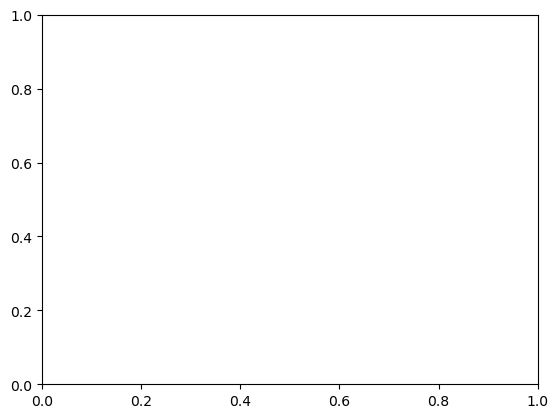

In [12]:
hrs = np.arange(10)

index = 0

plt.plot(hrs, X_train[index,:,0], label='solar_radiation')
plt.plot(hrs, X_train[index,:,1], label='relative_humidity')
plt.plot(hrs, X_train[index,:,2], label='CN2')
plt.plot(hrs, X_train[index,:,3], label='Temperature')
plt.legend()
plt.show()

Augment the dataset

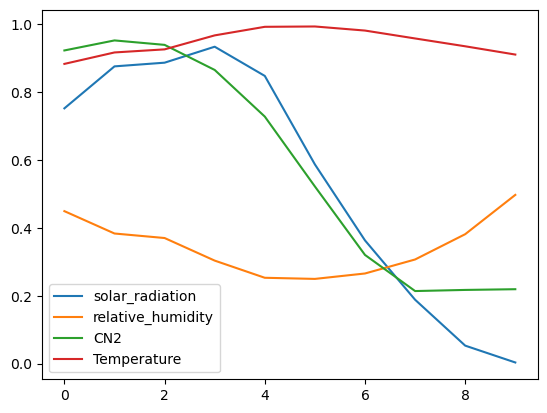

In [146]:
X_aug = window_warp(X_train)
hrs = np.arange(10)


index = 9

plt.plot(hrs, X_aug[index,:,0], label='solar_radiation')
plt.plot(hrs, X_aug[index,:,1], label='relative_humidity')
plt.plot(hrs, X_aug[index,:,2], label='CN2')
plt.plot(hrs, X_aug[index,:,3], label='Temperature')
plt.legend()
plt.show()


# Plot the Distribution of CN2 values

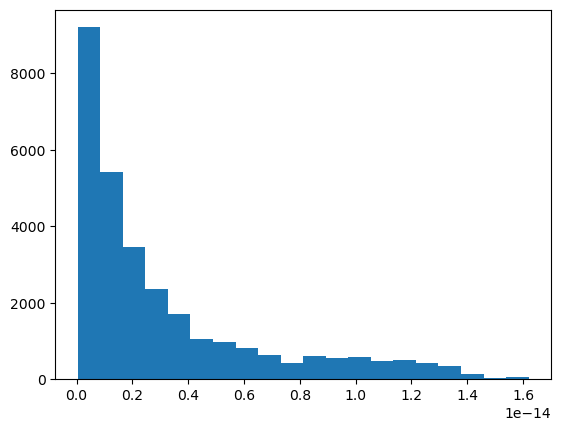

In [23]:
cn2_hist_train = 10**(unnorm_data(y_train.flatten(), minOut, maxOut))
cn2_hist_test = 10**(unnorm_data(y_test.flatten(), minOut, maxOut))

cn2_hist_max = np.array([np.max(datapt) for datapt in cn2_hist_train])
cn2_hist_min = np.array([np.min(datapt) for datapt in cn2_hist_train])

hist, bins,_ = plt.hist(cn2_hist_min, bins=20)

To give a sense of any possible bias within the training dataset, make a histogram of $CN^{2}$ values

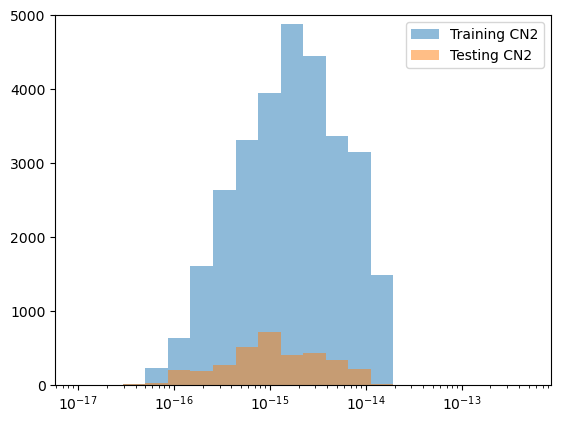

In [24]:
logbins = np.logspace(np.log10(1e-17),np.log10(5e-13), len(bins))

plt.hist(cn2_hist_train, bins=logbins, label = 'Training CN2', alpha=0.5)
plt.hist(cn2_hist_test, bins=logbins, label = 'Testing CN2', alpha=0.5)
plt.xscale('log')
plt.ylim(0,5000)
plt.legend()

# Load trained model

Let's start with the static prediction ones

In [ ]:
# Static prediction models 

static_direc = 'Static Time Prediction/'


static_1 = static_direc + 'trainStatic1_1682'
static_2 = static_direc + 'trainStatic2_6543'
static_3 = static_direc + 'trainStatic3_8010'
static_4 = static_direc + 'trainStatic4_9970'
static_5 = static_direc + 'trainStatic5_2533'
static_6 = static_direc + 'trainStatic6_7528'
static_7 = static_direc + 'trainStatic7_3682'
static_8 = static_direc + 'trainStatic8_3620'
static_9 = static_direc + 'trainStatic9_2710'
static_10 = static_direc + 'trainStatic10_2452'
static_11 = static_direc + 'trainStatic11_9227'
static_12 = static_direc + 'trainStatic12_3873'




static_direcs = [static_1, static_2, static_3, static_4, static_5, static_6, static_7, static_8, static_9, static_10, static_11, static_12]
loaded_models = []

for static_model in static_direcs:
    loaded_models.append()
    


In [181]:
def mse_mod(y_true, y_pred):

    loss = K.mean(K.square(y_pred - y_true), axis=-1)
    loss_true = tf.reduce_mean(loss)
    
    # We add a small epsillion to the MSE. This makes it so that we avoid crazy losses
    return loss_true + 1e-8


# Model directories

# Week of March 4th Models

vinso_12_2 = 'timeSeries12_320Neurons_3Window_1310'
vinso_12 = 'timeSeries12_wider_5518'
vinso_9 = 'timeSeries9_4975'
vinso_6 = 'timeSeries6_8843'
vinso_3 = 'timeSeries3_4870'


# March 12th models

singleShot_12 = 'timeSeries12_singleShot_base_6691'
singleShot_9 = 'timeSeries9_singleShot_1319'
singleShot_6 = 'timeSeries6_singleShot_7836'
singleShot_biDirec = 'timeSeries12_base_bidirec_2662'

# March 18th Models

jitter = 'train12_jitter_6858'
windowSlice = 'train12_window_slice_3733'
windowWarp = 'train12_windowwarp_3911'
oneWindow = 'timeSeries12_base_oneWindow_5550'


# Feature Engineered Models

diff_11 = "train_diff_11_8528"
diff_13 = "train_diff_13_2342"

# Varying forecast models

train_2 = 'TrainSeries2_4244'
train_3 = 'TrainSeries3_7021'
train_4 = 'TrainSeries4_3986'
train_5 = 'trainSeries5_6144'
train_6 = 'trainSeries6_8141'
train_7 = 'trainSeries7_3798'
train_8 = 'trainSeries8_5771'
train_9 = 'trainSeries9_7705'
train_10 = 'trainSeries10_3605'
train_11 = 'trainSeries11_3402'

# 4 Hour predictions using the latest normalization technology 

train_4_new = 'trainSeries_4Hour_9339'
train_4_old = 'TrainSeries4_3986'

# Latest models w/ higher time resolution 

#highTimeRes_30k = 'trainSeries_60Min_30k_6757'
highTimeRes_30k = 'trainSeriesMin_lossMSE_4818'


highTimeRes_38k = 'trainSeriesMin_lossMSE_2547'


# More complicated network 
highTimeRes_moreNeurons = 'trainSeriesMin_12hr_1400Neurons_4672'

# w/ 61 minute time skip 
highTimeRes_61MinSkip = 'trainSeries_61Min_Skip_3898'

# one hour time window 
highTimeRes_oneHourWindow = 'trainSeries_oneHourWindow_1659'

# Four Hours
highTimeRes_FourHour = 'trainSeries_oneHourWindow_4Hour_5364'

# Load the models

loaded_model_1 = tf.keras.models.load_model(f'models/{highTimeRes_FourHour}', custom_objects={'mse_mod':mse_mod})
#loaded_model_2 = tf.keras.models.load_model(f'models/{train_4_old}')

For the time series, let's plot some predictions. Design a colormap based on the RMSE between points

In [203]:
def rms(y_true, y_pred):
    root_mean = np.sqrt((y_true - y_pred)**2)
    return root_mean 

def rms_true(y_true, y_pred):
    root_mean = np.sqrt(np.mean((y_true - y_pred)**2))
    return root_mean

time_len = 240

index= 80
X_test_pred = tf.expand_dims(X_test[index], axis=0)
ronso = loaded_model_1.predict(X_test_pred, verbose=False)
ronso = np.array(ronso[0]).flatten()
truth = np.array(y_test[index]).flatten()
error_gradient =rms(truth[:time_len], ronso[:time_len])
print(np.mean(error_gradient))
hrs = np.arange(time_len)

# For plotting, unnormalize

truth = 10**(unnorm_data(truth, minOut, maxOut))
ronso = 10**(unnorm_data(ronso, minOut, maxOut))


0.08018958341651636


In [204]:
error_gradient

array([1.75231144e-02, 3.69260797e-02, 3.61421611e-02, 6.37737532e-03,
       2.90419963e-02, 2.39594310e-02, 2.16489165e-02, 2.30629547e-02,
       4.15756952e-02, 1.61114488e-02, 1.04251960e-02, 2.30311828e-02,
       1.51367560e-02, 2.91509411e-02, 1.84896965e-02, 1.57010336e-02,
       6.42458387e-03, 1.47338017e-02, 1.29280194e-02, 1.78865747e-05,
       4.96900600e-03, 1.31364215e-02, 3.13860134e-03, 1.47967939e-02,
       1.35273958e-02, 1.73676428e-02, 7.59226102e-03, 1.90256275e-02,
       1.08218230e-02, 2.73532106e-03, 9.95619408e-04, 5.81715088e-03,
       1.48890302e-02, 1.65230989e-02, 3.81299095e-02, 4.20907165e-04,
       2.38168926e-02, 2.02707139e-02, 2.13929072e-02, 1.58906236e-02,
       1.75821205e-02, 1.67492018e-02, 1.11879168e-03, 2.81462794e-02,
       3.14774904e-02, 1.46998280e-02, 3.81033811e-02, 3.26062352e-02,
       1.05012979e-02, 2.69864378e-02, 4.38795513e-02, 4.57402891e-02,
       4.61266833e-02, 3.69104594e-02, 3.89346202e-02, 4.98935112e-02,
      

Text(0.5, 1.0, 'Average RMSE: 0.08018958341651636')

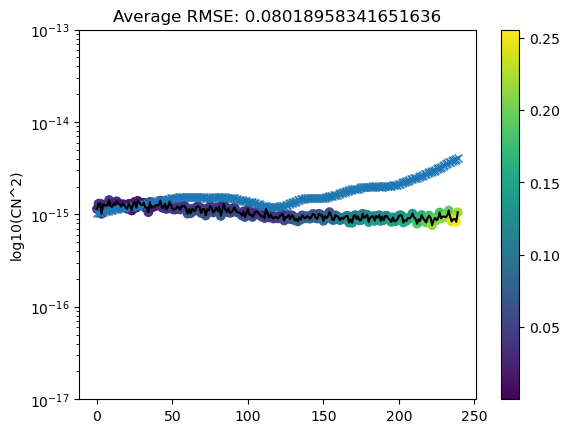

In [205]:
plt.plot(hrs, truth[:time_len], marker = 'x')
plt.scatter(hrs, ronso[:time_len] , c = error_gradient[:time_len], cmap='viridis', marker = 'o')
plt.plot(hrs, ronso[:time_len], color='black')
plt.colorbar()
plt.ylabel('log10(CN^2)')
plt.ylim(10**-17, 10**-13)
plt.yscale('log')
plt.title(f'Average RMSE: {np.mean(error_gradient)}')

To compare performance between two models, let's make subplots showcasing both predictions 

In [63]:
index = 48
X_test_pred = tf.expand_dims(X_test[index], axis=0)
ronso = loaded_model_1.predict(X_test_pred, verbose=False)
ronso = np.array(ronso[0]).flatten()
truth = np.array(y_test[index]).flatten()

error_gradient =rms(truth[:time_len], ronso[:time_len])
hrs = np.arange(time_len-2)

# For plotting, unnormalize
ronso_2 = loaded_model_2.predict(X_test_pred, verbose=False)
ronso_2 = np.array(ronso_2[0]).flatten()
error_gradient_2 = rms(truth[:time_len], ronso_2[:time_len])

# Unnormalize

truth = 10**(unnorm_data(truth, minOut, maxOut))
ronso = 10**(unnorm_data(ronso, minOut, maxOut))
ronso_2 = 10**(unnorm_data(ronso_2, minOut, maxOut))

# Make plots for both 

fig, ax = plt.subplots(1,2, figsize=(20,10))

ax[0].plot(hrs, truth[:time_len-2], marker = 'x')
im1 = ax[0].scatter(hrs, ronso[:time_len-2] , c = error_gradient[:10], cmap='viridis', marker = 'o')
ax[0].plot(hrs, ronso[:time_len-2], color='black')
cbar1 = plt.colorbar(im1, ax=ax[0])

ax[0].set_ylabel('log10(CN^2)')
ax[0].set_ylim(10**-17, 10**-13)
ax[0].set_yscale('log')
ax[0].set_title('With Bidirectional Layers')


ax[1].plot(hrs, truth[:time_len-2], marker = 'x')
im2 = ax[1].scatter(hrs, ronso_2[:time_len-2], c= error_gradient_2[:10])
ax[1].plot(hrs, ronso_2[:time_len-2], color='black')
cbar2 = plt.colorbar(im2, ax=ax[1])
ax[1].set_title('Without Bidirectional Layers')


ax[1].set_ylabel('log10(CN^2)')
ax[1].set_ylim(10**-17, 10**-13)
ax[1].set_yscale('log')


NameError: name 'loaded_model_2' is not defined

Let's compute an overall metric ... how about computing the RMSE over the entire testing dataset? 

In [90]:
RMSEs = []
#RMSEs_2 = []
#time_len_window = 4
#time_len_window_2 = 4
time_len_window = 720

for ii,x in enumerate(X_test):
    
    print(ii) 
    funky = tf.expand_dims(x, axis=0)
    
    preds = loaded_model_1.predict(funky, verbose=False)
    #preds_2 = loaded_model_2.predict(funky, verbose=False)
    
    truth = np.array(y_test[ii]).flatten()
    
    preds = np.array(preds[0]).flatten()
    #preds_2 = np.array(preds_2[0]).flatten()
    
    rmse = rms(truth[:time_len_window], preds[:time_len_window])
    #rmse_2 = rms(truth[:time_len_window_2], preds_2[:time_len_window_2])
    
    RMSEs.append(rmse)
    #RMSEs_2.append(rmse_2)
    if (ii>1000):
        print("finished")
        break; 

    
    
print(np.mean(RMSEs))   
#print(np.mean(RMSEs_2))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [88]:
np.shape(RMSEs_2)

NameError: name 'RMSEs_2' is not defined

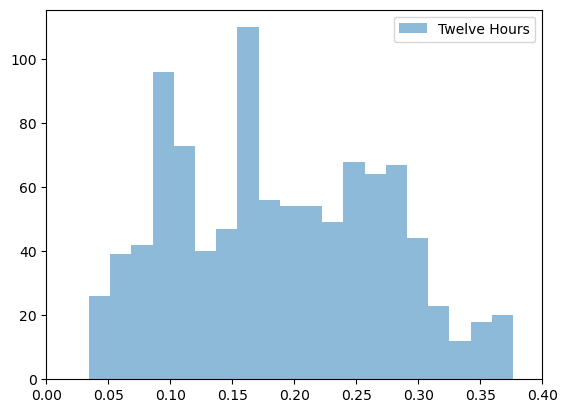

In [91]:
plt.hist(np.mean(RMSEs, axis=1), bins=20, label='Twelve Hours', alpha=0.5)
plt.xlim(0.0, 0.40)

#plt.hist(np.mean(RMSEs_2, axis=1), bins=80, label='Twelve Hours (Old Norm)', alpha=0.5)
plt.legend()

In [95]:
import heapq

def minN(lst, n=10):
    # Enumerate the list to pair each element with its index
    enumerated_lst = list(enumerate(lst))
    
    # Use heapq.nsmallest with a key function to sort by the list values
    smallest_elements_with_indices = heapq.nsmallest(n, enumerated_lst, key=lambda x: x[1])
    
    # Extract the indices and values separately if needed
    indices, values = zip(*smallest_elements_with_indices)
    
    return list(indices), list(values)


# same thing, but for n largest
def maxN(lst, n=10):
    # Enumerate the list to pair each element with its index
    enumerated_lst = list(enumerate(lst))
    
    # Use heapq.nlargest with a key function to sort by the list values
    largest_elements_with_indices = heapq.nlargest(n, enumerated_lst, key=lambda x: x[1])
    
    # Extract the indices and values separately if needed
    indices, values = zip(*largest_elements_with_indices)
    
    return list(indices), list(values)

mean_RMSEs = np.mean(RMSEs, axis=1)

In [162]:
total_indices = np.arange(len(mean_RMSEs))
max_indices,_ = maxN(mean_RMSEs, n=300)
min_indices,_ = minN(mean_RMSEs, n=300)


total_minus_max = np.setdiff1d(total_indices, max_indices)
central_indices = np.setdiff1d(total_minus_max, min_indices)


central_indices.sort()
    

In [163]:
central_indices

array([  15,   16,   17,   18,   19,   20,   21,   22,   23,   24,   25,
         26,   27,   28,   29,   30,   31,   32,   33,   34,   35,   36,
         37,   38,   39,   40,   41,   42,   43,   44,   45,   46,   47,
         48,   49,  117,  118,  119,  120,  121,  122,  123,  124,  125,
        126,  127,  128,  129,  130,  131,  132,  133,  134,  135,  136,
        137,  138,  139,  140,  141,  142,  143,  144,  145,  146,  147,
        148,  149,  150,  151,  152,  153,  154,  155,  156,  157,  158,
        159,  160,  161,  162,  163,  164,  165,  166,  167,  168,  169,
        170,  171,  172,  173,  174,  175,  176,  177,  178,  179,  180,
        181,  182,  183,  184,  185,  186,  187,  188,  189,  190,  191,
        192,  193,  194,  195,  196,  197,  198,  199,  200,  201,  202,
        203,  204,  205,  206,  207,  208,  209,  210,  211,  212,  213,
        214,  215,  216,  217,  218,  219,  220,  221,  222,  223,  224,
        225,  226,  227,  228,  229,  230,  231,  2

# Plotting Test RMSE vs. Forecast Length 

Text(0.5, 0, 'Forecast Series Length')

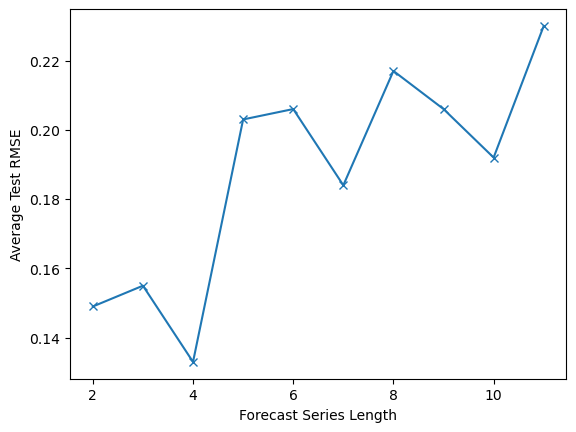

In [69]:
RMSEs_forecast = [0.149, 0.155, 0.133, 0.203, 0.206, 0.184, 0.217, 0.206, 0.192, 0.23]
timeLens = np.arange(2,12)
plt.plot(timeLens, RMSEs_forecast, marker = 'x')
plt.ylabel('Average Test RMSE')
plt.xlabel('Forecast Series Length')

# Static Predictions

Plot model prediction vs. ground truths

In [64]:
model_predictions = []

for ii,x in enumerate(X_roll_test):
    print(ii)
    funky = tf.expand_dims(x, axis=0)
    preds = loaded_model.predict(funky, verbose=False)
    model_predictions.append(preds)
    
model_predictions = np.array(model_predictions)
Cn2_pred = model_predictions[:,0,0]
#r0_pred = model_predictions[:,0,1]

Cn2_true = y_test[:,0,0]
#r0_true = y_test[:,0,1]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

Results on training data
Slope:1.113320864494608, intercept:-0.021167209522354943, r_value:0.8036351205908453


Text(0.5, 1.0, 'Ground Truths vs. Model Predictions -- $CN^2$\nR2 Value: 0.8036351205908453 -- Slope of Best Fit: 1.113320864494608')

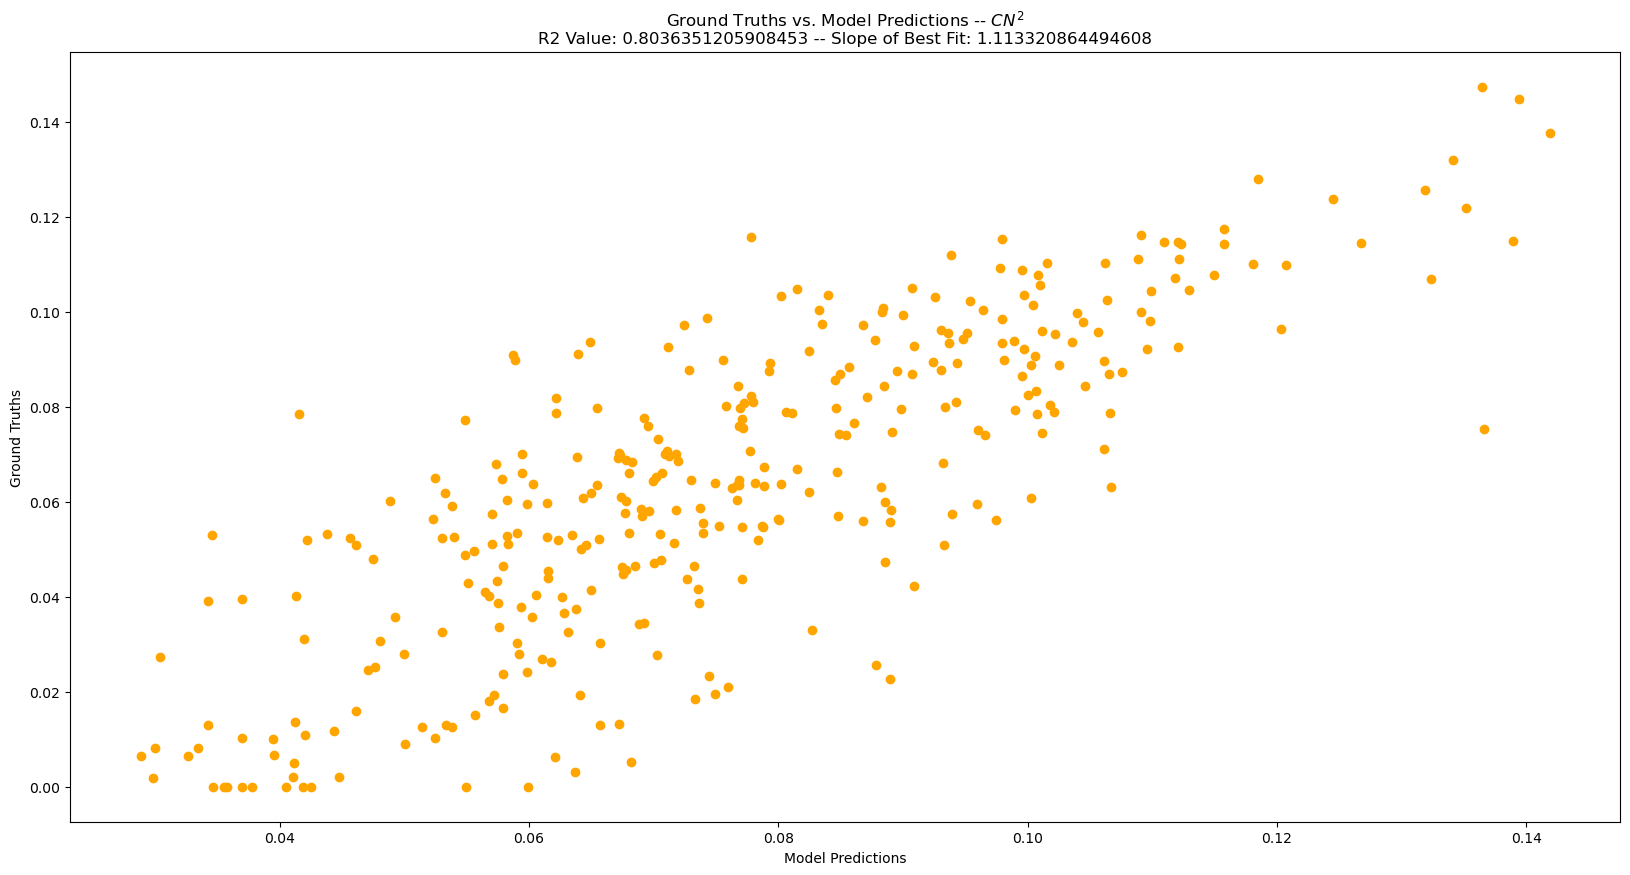

In [65]:
# Compute R2 value

slope_cn, intercept_cn, r_value_cn, p_value_cn, std_err_cn = stats.linregress(Cn2_pred, Cn2_true)

print("Results on training data")
print(f"Slope:{slope_cn}, intercept:{intercept_cn}, r_value:{r_value_cn}")

#slope_r0, intercept_r0, r_value_r0, p_value_r0, std_err_r0 = stats.linregress(r0_pred, r0_true)

#print("Results on training data")
#print(f"Slope:{slope_r0}, intercept:{intercept_r0}, r_value:{r_value_r0}")

fig, ax = plt.subplots(1,1, figsize=(20,10))


ax.scatter(Cn2_pred, Cn2_true, color='orange')
ax.set_xlabel('Model Predictions')
ax.set_ylabel('Ground Truths')
#ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_title(f'Ground Truths vs. Model Predictions -- $CN^{2}$\nR2 Value: {r_value_cn} -- Slope of Best Fit: {slope_cn}')



#plt.savefig(f'R2Plots/{model_direc}.png', bbox_inches='tight')